In [3]:
import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import tensorflow_hub as hub
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from classification_models.tfkeras import Classifiers

In [4]:
gpu_available = tf.config.list_physical_devices('GPU')
gpu_available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1. DATA PREPROCESSING

In [5]:
directory_train = "keras_insect_splited/train"
directory_val = "keras_insect_splited/val"
directory_test = "keras_insect_splited/test"

In [6]:
BATCH_SIZE = 32
IMG_SIZE = 224

HORIZONTAL_FLIP=True
VERTICAL_FLIP=True
# ROTATION_RANGE=40
# WIDTH_SHIFT_RANGE=0.2
# HEIGHT_SHIFT_RANGE=0.2
# SHEAR_RANGE=0.2
# ZOOM_RANGE=0.1
# BRIGHTNESS_RANGE=[0.8,1.2]

In [7]:
#ImageDataGenerator accepts file types: 'png', 'jpg', 'jpeg', 'bmp', 'ppm', 'tif', 'tiff'

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=HORIZONTAL_FLIP,
    vertical_flip=VERTICAL_FLIP,
    )

In [8]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [29]:
train_generator = train_datagen.flow_from_directory(
    directory_train,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical", ## "categorical" will be 2D one-hot encoded labels
    shuffle=True
)

Found 3862 images belonging to 12 classes.


In [30]:
validation_generator = test_datagen.flow_from_directory(
        directory_val,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
)

Found 549 images belonging to 12 classes.


In [16]:
test_generator = test_datagen.flow_from_directory(
    directory_test,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1116
    #shuffle=False
)

Found 1116 images belonging to 12 classes.


In [10]:
target_labels = next(os.walk(directory_train))[1]
target_labels.sort()
print(target_labels)

num_classes = len(target_labels)
print(num_classes)

['adalia bipunctata', 'calliteara pudibunda', 'cerambyx cerdo', 'gryllotalpa gryllotalpa', 'lucanus cervus', 'mantis religiosa', 'melolontha melolontha', 'phyrrochorus apterus', 'rhaphigaster nebulosa', 'sesia apiformis', 'tettigonia viridissima', 'xylocopa violacea']
12


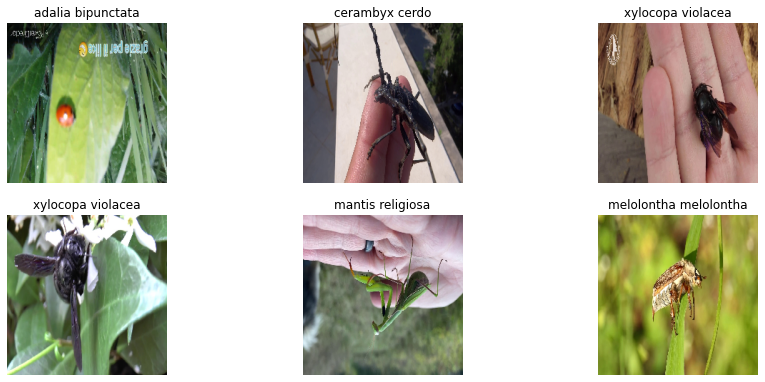

In [33]:
batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

plt.figure(figsize=(15,10))
for n, i in enumerate(np.arange(6)):
    ax = plt.subplot(3,3,n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.argmax(batch_labels[i])])
    plt.axis('off')

2. CREATING A NEW TRAINING MODEL OR USING PRETRAINED MODEL???

In [34]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
model = ResNet18((IMG_SIZE, IMG_SIZE, 3), weights='imagenet')

base_model = model
#base_model.summary()

In [35]:
base_model = ResNet18(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])
#model.summary()

In [36]:
# for layer in model_imported.layers[:-3]:
#     layer.trainable = True

# for l in model_imported.layers:
#     print(l.name, " - ", l.trainable)

In [37]:
def pretrained_weights(model):
    
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [38]:
new_model = pretrained_weights(model)
new_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 224, 224, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_54 (ZeroPadding  (None, 230, 230, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

In [39]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=1, patience=20),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=15, min_lr=1e-20, verbose=1, cooldown=3),
    tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/best_model.h5", monitor='val_accuracy', mode='max', save_best_only=True)
    ]

In [40]:
def train_model(model, train_gen, valid_gen, epochs):
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    valid_steps_per_epoch = valid_gen.n // valid_gen.batch_size

    history = model.fit(
        train_gen,
        steps_per_epoch=train_steps_per_epoch,
        epochs=epochs,
        validation_steps=valid_steps_per_epoch,
        callbacks=my_callbacks,
        validation_data=valid_gen
    )

    return history

In [41]:
history_frozen_model = train_model(new_model, train_generator, validation_generator, epochs=80
)

Epoch 1/80
120/120 [==============================] - 66s 530ms/step - loss: 0.5604 - accuracy: 0.8446 - val_loss: 3.9195 - val_accuracy: 0.0790 - lr: 0.0010
Epoch 2/80
120/120 [==============================] - 63s 522ms/step - loss: 0.2069 - accuracy: 0.9428 - val_loss: 5.2805 - val_accuracy: 0.0901 - lr: 0.0010
Epoch 3/80
120/120 [==============================] - 61s 506ms/step - loss: 0.2036 - accuracy: 0.9467 - val_loss: 7.0745 - val_accuracy: 0.0662 - lr: 0.0010
Epoch 4/80
120/120 [==============================] - 61s 510ms/step - loss: 0.1404 - accuracy: 0.9585 - val_loss: 4.4894 - val_accuracy: 0.0827 - lr: 0.0010
Epoch 5/80
120/120 [==============================] - 61s 504ms/step - loss: 0.0965 - accuracy: 0.9674 - val_loss: 8.2306 - val_accuracy: 0.0662 - lr: 0.0010
Epoch 6/80
120/120 [==============================] - 62s 519ms/step - loss: 0.1027 - accuracy: 0.9674 - val_loss: 5.2976 - val_accuracy: 0.0827 - lr: 0.0010
Epoch 7/80
120/120 [==============================] 

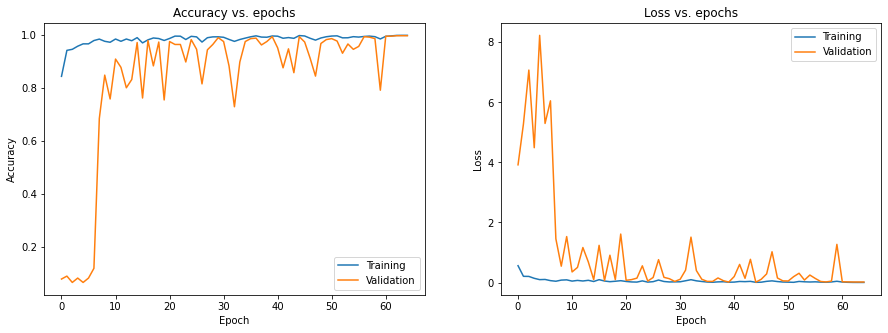

In [42]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_frozen_model.history['accuracy'])
plt.plot(history_frozen_model.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_frozen_model.history['loss'])
plt.plot(history_frozen_model.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [11]:
from tensorflow import keras

loaded_model = keras.models.load_model("saved_models/best_model.h5")
#loaded_model.summary()

In [12]:
new_model_test_loss, new_model_test_acc = loaded_model.evaluate(test_generator)

print('\nTest dataset')
print(f"Loss: {new_model_test_loss}")
print(f"Accuracy: {new_model_test_acc}")

35/35 [==============================] - 21s 451ms/step - loss: 0.0281 - accuracy: 0.9928

Test dataset
Loss: 0.028145605698227882
Accuracy: 0.9928315281867981


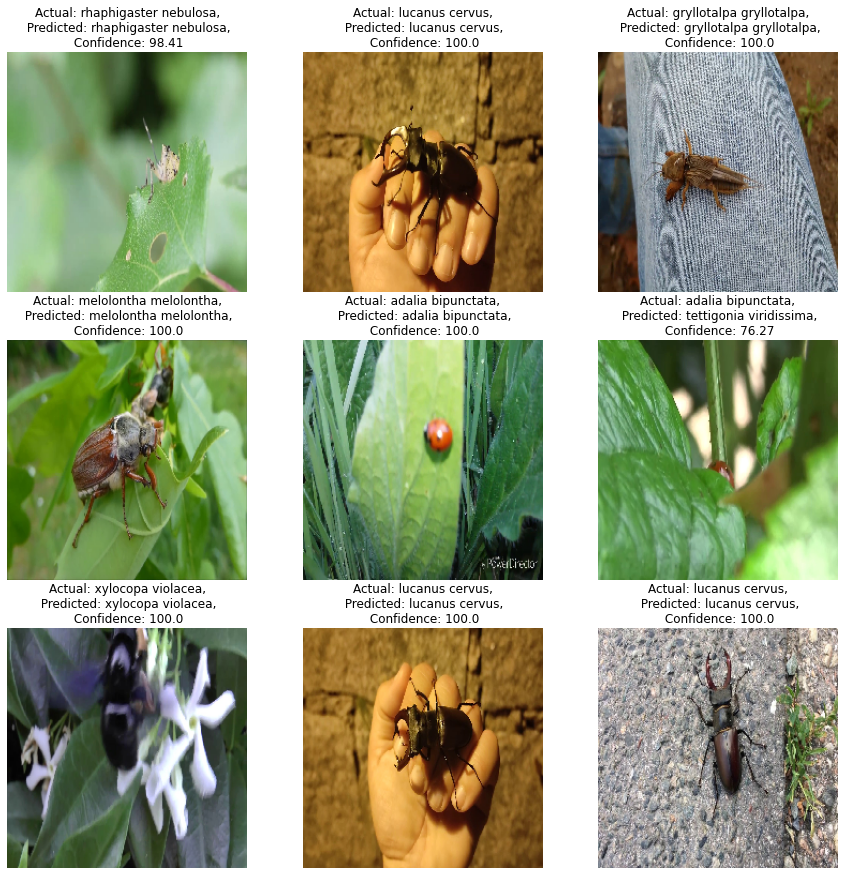

In [19]:
images, labels = next(test_generator)

plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i])

    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = loaded_model.predict(img_array)
    
    predicted_class = target_labels[np.argmax(predictions[0])]

    confidence = round(100*(np.max(predictions[0])), 2)

    actual_class = target_labels[np.argmax(labels[i])]
    

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")
    plt.axis("off")

In [20]:
y_true_lista = []
y_pred_lista = []

images, labels = next(test_generator)
print(len(images))

for i in range(len(images)):

    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = loaded_model.predict(img_array)

    predicted_class = np.argmax(predictions[0])
    y_pred_lista.append(predicted_class)

    actual_class = np.argmax(labels[i])
    actual_class = actual_class
    y_true_lista.append(actual_class)

# print("y_true_lista: ", y_true_lista)
# print("y_pred_lista: ", y_pred_lista)

1116


<AxesSubplot:>

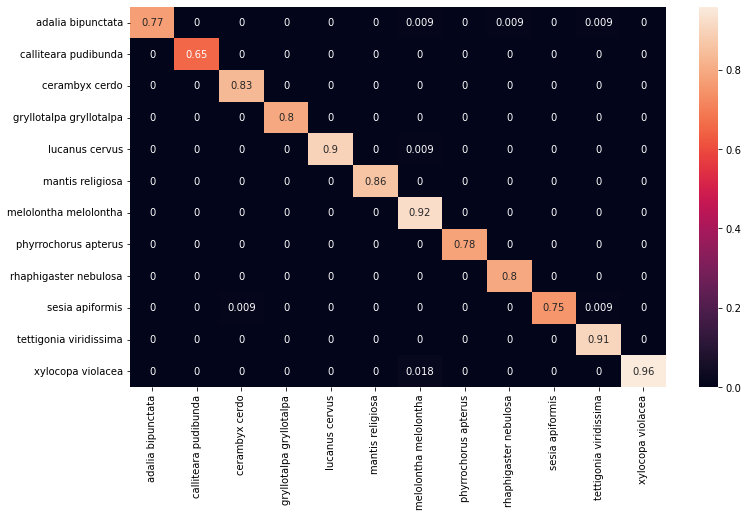

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cf_matrix = confusion_matrix(y_true_lista, y_pred_lista)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in target_labels],
                     columns = [i for i in target_labels])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform

np_image = Image.open("frame2190.jpg")
np_image = np.array(np_image).astype('float32')/255

np_image = transform.resize(np_image, (224, 224, 3))
np_image = np.expand_dims(np_image, axis=0)

prediction = loaded_model.predict(np_image)
predicted_name = target_labels[np.argmax(prediction[0])]
predicted_name